# 4. Modeling - Sales Forecast

## Contents
- 4.1 [Introduction](#3.1Introduction)
- 4.2 [Import, Load, Explore](#3.2-Import,Load,Explore)
   - 4.2.1 [Loading train, test, and validation datasets](#3.2.1.Quantity) 
- 4.3 [Initial exploration](#3.3.ExploringTemproralPattern)
- 4.4 [Model Selection](#3.4.Subset&analyze)
   - 4.4.1 [ARIMA model](#3.2.3.StockCode)
   - 4.4.2 [Prophet](#3.2.4.CustomerID)
   - 4.4.3 [LSTM](#3.2.5.Country) 
- 4.5 [Final Model Building](#3.5.Summary)
- 4.6 [Summary](#3.5.Summary)


## 4.1 Introduction <a id="3.1Introduction"></a>
In this phase, I'll explore 3 different models to forecast, after evaluating each on the validation set, the final model will be selected. 

## 4.2 Install & Import packages<a id="3.2-Import,Load,Explore"></a>


In [90]:
!pip install pmdarima

   ---------------------------------------- 0.0/614.7 kB ? eta -:--:--
   -- ------------------------------------ 41.0/614.7 kB 667.8 kB/s eta 0:00:01
   ------------ --------------------------- 194.6/614.7 kB 1.7 MB/s eta 0:00:01
   ---------------------------------------- 614.7/614.7 kB 3.9 MB/s eta 0:00:00


In [1]:
!pip install Cython

In [3]:
!pip install pystan==2.19.1.1

In [5]:
!pip install prophet

   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   ---------------------------------------- 0.1/13.3 MB 1.3 MB/s eta 0:00:11
    --------------------------------------- 0.2/13.3 MB 2.0 MB/s eta 0:00:07
   -- ------------------------------------- 0.8/13.3 MB 5.2 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/13.3 MB 10.2 MB/s eta 0:00:02
   --------- ------------------------------ 3.1/13.3 MB 12.5 MB/s eta 0:00:01
   ------------ --------------------------- 4.2/13.3 MB 14.1 MB/s eta 0:00:01
   --------------- ------------------------ 5.0/13.3 MB 15.2 MB/s eta 0:00:01
   ---------------- ----------------------- 5.6/13.3 MB 14.3 MB/s eta 0:00:01
   ---------------------- ----------------- 7.3/13.3 MB 16.8 MB/s eta 0:00:01
   ------------------------- -------------- 8.4/13.3 MB 17.3 MB/s eta 0:00:01
   ---------------------------- ----------- 9.4/13.3 MB 18.3 MB/s eta 0:00:01
   --

In [248]:
!pip install tensorflow

     ---------------------------------------- 0.0/57.5 kB ? eta -:--:--
     ---------------------------------------- 57.5/57.5 kB 3.0 MB/s eta 0:00:00
     ---------------------------------------- 0.0/65.5 kB ? eta -:--:--
     ---------------------------------------- 65.5/65.5 kB 3.7 MB/s eta 0:00:00
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
     ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
     ------------------------ --------------- 0.9/1.5 MB 28.7 MB/s eta 0:00:01
     ---------------------------------------- 1.5/1.5 MB 23.8 MB/s eta 0:00:00
  Using cached cachetools-5.3.2-py3-none-any.whl.metadata (5.2 kB)
     ---------------------------------------- 0.0/151.7 kB ? eta -:--:--
     -------------------------------------- 151.7/151.7 kB 9.4 MB/s eta 0:00:00
   ---------------------------------------- 0.0/300.9 MB ? eta -:--:--
   ---------------------------------------- 1.0/300.9 MB 33.0 MB/s eta 0:00:10
   ----------------------------

In [540]:
#Importing relevant libraries
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import tensorflow as tf
from prophet import Prophet
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import InputLayer, LSTM, Dense
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.losses import MeanSquaredError 
from tensorflow.keras.metrics import RootMeanSquaredError 
from tensorflow.keras.optimizers import Adam


### 4.2.1 Loading train, test, and validation datasets

In [286]:
#Loading training data

train_data = pd.read_csv("train_forecast.csv")
train_data

,WeekStartDate,Category,CustomerPerCategory,Quantity
0,2011-01-10,-1,1742125,302
1,2011-01-10,0,213684035,73059
2,2011-01-10,1,1143028,1905
3,2011-01-10,2,860000,528
4,2011-01-10,3,390285,290
...,...,...,...,...
331,2011-09-26,6,134212,250
332,2011-09-26,7,18941,21
333,2011-10-03,-1,1742125,1325
334,2011-10-03,0,213684035,166865


In [287]:
train_data['WeekStartDate'] = pd.to_datetime(train_data['WeekStartDate'])

In [288]:
train_data = train_data.set_index('WeekStartDate')

In [289]:
train_data.columns

Index(['Category', 'CustomerPerCategory', 'Quantity'], dtype='object')

In [290]:
#subseting records of Category 0 train data.
Category_0_train = train_data[train_data['Category'] == 0]

In [291]:
#Loading testing data
test_data = pd.read_csv("test_forecast.csv", parse_dates=['WeekStartDate'])
test_data.shape

(85, 4)

In [292]:
#Spliting into testing and validation data
val_data = test_data.iloc[:-43]
test_data = test_data.iloc[-43:]
val_data.shape, test_data.shape

((42, 4), (43, 4))

In [293]:
val_data.dtypes

WeekStartDate          datetime64[ns]
Category                        int64
CustomerPerCategory             int64
Quantity                        int64
dtype: object

In [294]:
val_data = val_data.set_index('WeekStartDate')

In [295]:
# subseting records of Category 0 validation data and test data.

Category_0_val = val_data[val_data['Category'] == 0]
Category_0_test = test_data[test_data['Category'] == 0]

In [296]:
#columns = ['CustomerPerCategory', 'Quantity']
#for column in columns:
   # print(f"Checking stationarity for {column}:")
   # ad_test(train_data[column])
   # print('\n')


In [297]:
#print('Is Quantity caused by number of CustomerPerCategory?') 
#print('_______________________________________________________')
#result = grangercausalitytests(
#    train_data[['CustomerPerCategory', 'Quantity']]
 #   , 12)

The p-value is greater than 0.05 significance level for all lags. This suggests that there is not enough evidence to conclude that the lagged values of the potential causal variable have a statistically significant impact on predicting the current values of the target variable.

## 4.3 Initial exploration <a id="3.2.1.Quantity"></a>

In [298]:
#checking for stationarity

def ad_test(data):
    result = adfuller(data, autolag = 'AIC')
    print('ADF: ', result[0])
    print('p-value: ', result[1])
    print('Num of lags: ', result[2])
    print('Num of observations used:', result[3])
    print('Critical values: ')
    for key, val in result[4].items():
        print(key, ":", val)

In [406]:
ad_test(Category_0_train['Quantity'])

ADF:  2.9878370296764754
p-value:  1.0
Num of lags:  10
Num of observations used: 28
Critical values: 
1% : -3.6889256286443146
5% : -2.9719894897959187
10% : -2.6252957653061224


since the 
p-value for quantity is higher than 0.05, we can conclude that the quuantity data for Category 0 is not stationary.

In [418]:
# differencing

train_diff_0 = Category_0_train.diff().dropna()

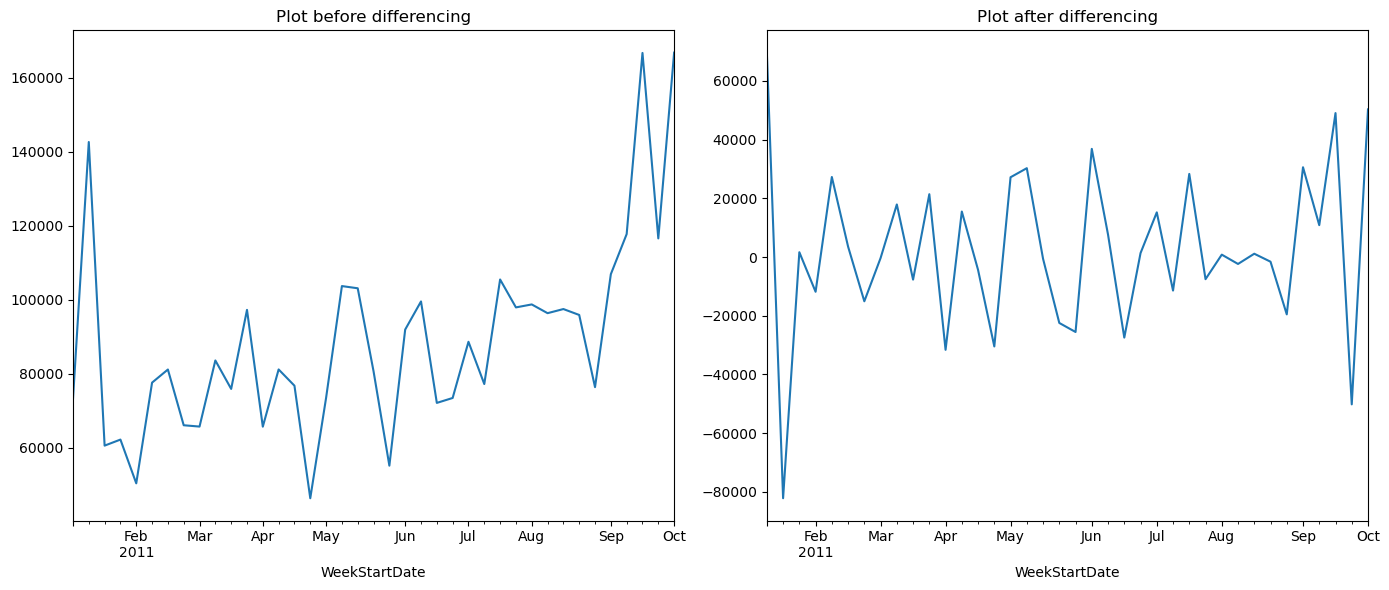

In [521]:

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
Category_0_train['Quantity'].plot()
plt.title('Plot before differencing')


plt.subplot(1, 2, 2) 
train_diff_0['Quantity'].plot()
plt.title('Plot after differencing')

plt.tight_layout()
plt.show()

In [419]:
stepwise_fit = auto_arima(train_diff_0['Quantity'],
                         trace = True, suppress_warnings = True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=886.426, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=891.102, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=883.272, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=884.785, Time=0.02 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=889.389, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=885.806, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=885.898, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=888.745, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=881.515, Time=0.02 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=884.103, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=881.454, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=879.380, Time=0.02 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=880.348, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=881.636, Time=0.06 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   38
Model:               SARIMAX(0, 0, 1)   Log Likelihood                -437.690
Date:                Sat, 20 Jan 2024   AIC                            879.380
Time:                        18:07:30   BIC                            882.656
Sample:                    01-17-2011   HQIC                           880.546
                         - 10-03-2011                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6852      0.109     -6.312      0.000      -0.898      -0.472
sigma2      4.277e+08    4.5e-11    9.5e+18      0.000    4.28e+08    4.28e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.25
Prob(Q):                              1.00   Prob(JB):                         0.53
Heteroskedasticity (H):               1.01   Skew:                             0.39
Prob(H) (two-sided):                  0.99   Kurtosis:                         3.45
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.64e+34. Standard errors may be unstable.
"""

##  4.4 Model Selection

### 4.4.1 ARIMA model

In [493]:
model_ARIMA = ARIMA(train_diff_0['Quantity'], order = (1,0,2))
results_ARIMA = model_ARIMA.fit()
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:               Quantity   No. Observations:                   38
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -436.785
Date:                Sat, 20 Jan 2024   AIC                            883.570
Time:                        18:42:30   BIC                            891.758
Sample:                    01-17-2011   HQIC                           886.483
                         - 10-03-2011                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       2468.5629   1183.754      2.085      0.037     148.448    4788.678
ar.L1         -0.9206      0.205     -4.486      0.000      -1.323      -0.518
ma.L1          0.1696      0.345      0.492      0.6

In [496]:
val_diff_0 = Category_0_val.diff().dropna()
test_diff_0 = Category_0_test.diff().dropna()

In [497]:
# Evaluating the ARIMA model

start_date = val_diff_0.index[0]
end_date = val_diff_0.index[-1] 

In [498]:
pred = results_ARIMA.predict(start = start_date, end = end_date)

<Axes: xlabel='WeekStartDate'>

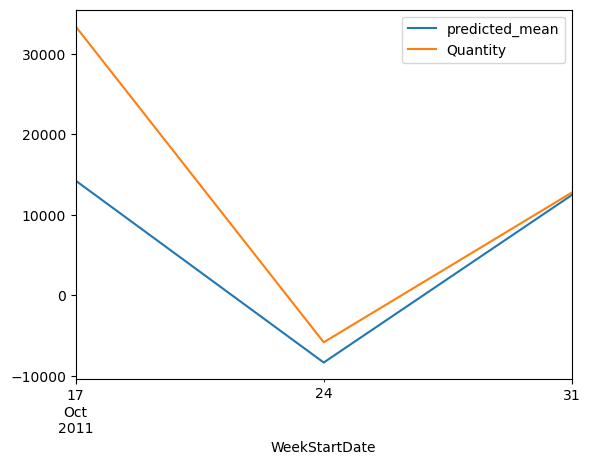

In [499]:
pred.plot(legend = True)
val_diff_0['Quantity'].plot(legend = True)

In [500]:
pred

2011-10-17    14229.276498
2011-10-24    -8358.892006
2011-10-31    12436.816748
Freq: W-MON, Name: predicted_mean, dtype: float64

In [501]:
residuals = val_diff_0['Quantity'] - pred

In [502]:
#Evaluating the model

# MAE
mae = mean_absolute_error(val_diff_0['Quantity'], pred)
print(f'MAE: {round(mae, 2)}')

# MSE
mse = mean_squared_error(val_diff_0['Quantity'], pred)
print(f'MSE: {round(mse, 2)}')

# RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {round(rmse, 2)}')

# MAPE
mape = np.mean(np.abs((val_diff_0['Quantity']- pred) / val_diff_0['Quantity'])) * 100
print(f'MAPE: {mape:.2f}%')

MAE: 7325.6
MSE: 124389107.35
RMSE: 11152.99
MAPE: 34.28%


### 4.4.2 Prophet model

In [359]:
train = pd.DataFrame({
    'ds': Category_0_train.index,
    'y': Category_0_train['Quantity']
})

In [360]:
m = Prophet()
prophet_model = m.fit(train)


16:49:26 - cmdstanpy - INFO - Chain [1] start processing
16:49:26 - cmdstanpy - INFO - Chain [1] done processing


In [368]:
#Prediction

future = m.make_future_dataframe(periods = 4 , freq = 'W')
forecast = m.predict(future)

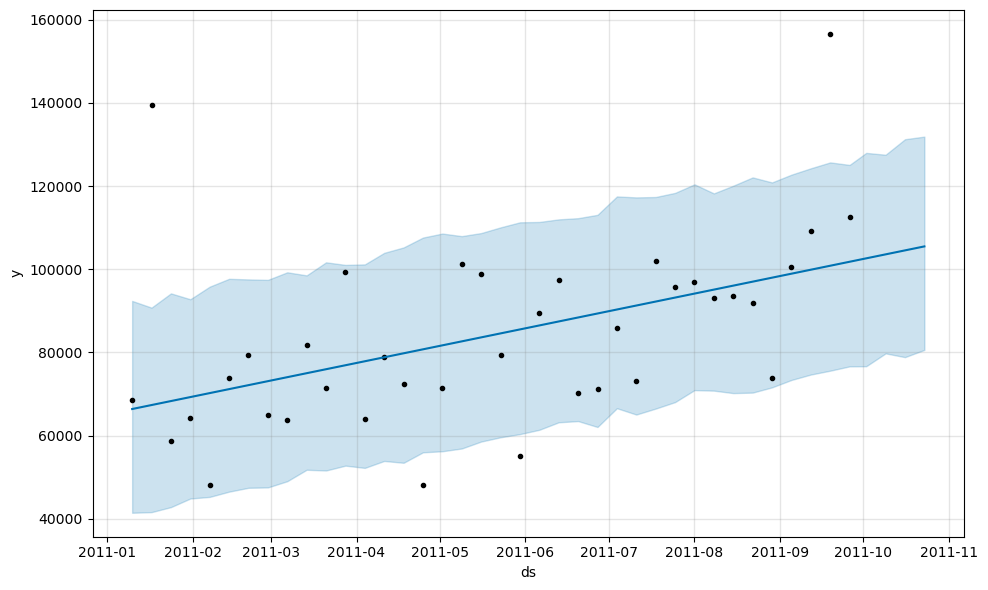

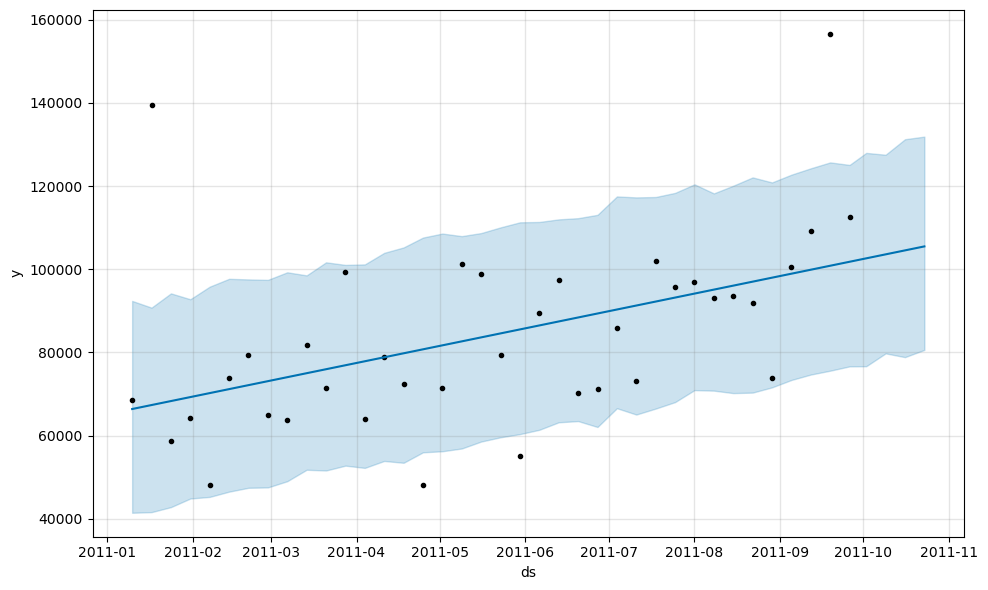

In [246]:
m.plot(forecast)

In [377]:
predicted = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].iloc[-4:]
predicted

,ds,yhat,yhat_lower,yhat_upper
39,2011-10-09,114547.441683,84538.476910,141387.081037
40,2011-10-16,115839.064735,88909.864113,146711.869060
41,2011-10-23,117130.687786,88323.310026,145129.942621
42,2011-10-30,118422.310838,90827.885266,146383.777990


In [390]:
residuals_p = Category_0_val['Quantity'] - predicted['yhat'].values

In [392]:
residuals_p

WeekStartDate
2011-10-10       -2.441683
2011-10-17    32085.935265
2011-10-24    24949.312214
2011-10-31    36406.689162
Name: Quantity, dtype: float64

In [511]:
predicted_p = predicted[['ds', 'yhat']].set_index('ds')

<Axes: xlabel='WeekStartDate'>

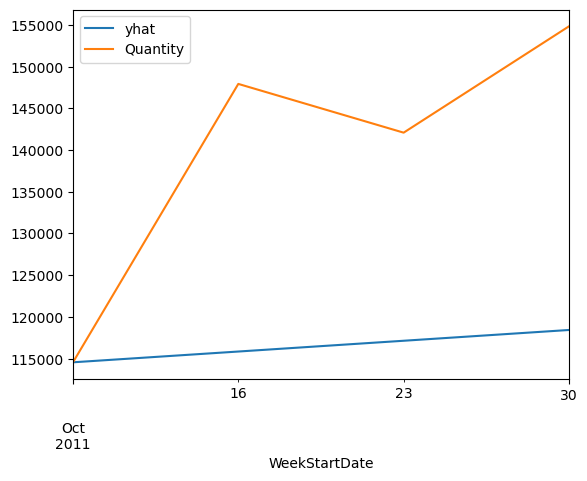

In [513]:
predicted_p['yhat'].plot(legend = True)
Category_0_val['Quantity'].plot(legend = True)

In [504]:
#Evaluating the model

# MAE
mae = mean_absolute_error(Category_0_val['Quantity'], predicted['yhat'].values)
print(f'MAE: {round(mae, 2)}')

# MSE
mse = mean_squared_error(Category_0_val['Quantity'], predicted['yhat'].values)
print(f'MSE: {round(mse, 2)}')

# RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {round(rmse, 2)}')

# MAPE
mape = np.mean(np.abs((Category_0_val['Quantity']- predicted['yhat'].values) / Category_0_val['Quantity'])) * 100
print(f'MAPE: {mape:.2f}%')

MAE: 23361.09
MSE: 744355610.87
RMSE: 27282.88
MAPE: 15.69%


### 4.4.3 LSTM

In [568]:
scaler = MinMaxScaler(feature_range=(0, 1))

train_scaled = scaler.fit_transform(Category_0_train['Quantity'].values.reshape(-1, 1) )

val_scaled = scaler.fit_transform(Category_0_val['Quantity'].values.reshape(-1, 1) )

test_scaled = scaler.fit_transform(Category_0_test['Quantity'].values.reshape(-1, 1) )

In [569]:
val_scaled

array([[0.        ],
       [0.82861682],
       [0.68352199],
       [1.        ]])

In [573]:
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

In [597]:
# Create sequences for training
X, y = create_sequences(train_scaled, 1)

# Reshape input data for LSTM model
X = X.reshape((X.shape[0], X.shape[1], 1))

In [598]:
model_LSTM = Sequential()
model_LSTM.add(LSTM(64, input_shape=(X.shape[1], 1)))
model_LSTM.add(Dense(1, activation='relu'))
model_LSTM.compile(optimizer='adam', loss='mean_squared_error')

In [599]:
model_LSTM.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 64)                16896     
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16961 (66.25 KB)
Trainable params: 16961 (66.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [600]:


def create_sequences_val(data, seq_length):
    sequences, targets = [], []
    for i in range(abs(len(data) - seq_length + 1)):
        seq = data[i:i + seq_length]
        target = data[i + seq_length - 1]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)



In [601]:
X_val, y_val  = create_sequences(val_scaled, 1)

In [602]:
y_val

array([[0.82861682],
       [0.68352199],
       [1.        ]])

In [603]:
# Evaluating model
loss = model_LSTM.evaluate(X_val, y_val)
print(f"Validation Loss: {loss}")

1/1 [==============================] - 0s 355ms/step - loss: 0.7179
Validation Loss: 0.7179360389709473


In [604]:
predictions = model_LSTM.predict(X_val)

1/1 [==============================] - 0s 435ms/step


In [605]:
# Inverse transform the predictions to the original scale
predictions_original_scale = scaler.inverse_transform(predictions)

# Optionally, you can compare predictions with actual values
compare_df = pd.DataFrame({'Actual': scaler.inverse_transform(y_val.reshape(-1, 1)).flatten(),
                            'Predicted': predictions_original_scale.flatten()})
print(compare_df)

          Actual  Predicted
0  164664.970907    85397.0
1  150784.764497    85397.0
2  181060.000000    85397.0


In [607]:
actual_LSTM = scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()
pred_LSTM = predictions_original_scale.flatten()

In [610]:
pred_LSTM = pd.Series(pred_LSTM) 
actual_LSTM = pd.Series(actual_LSTM) 


<Axes: >

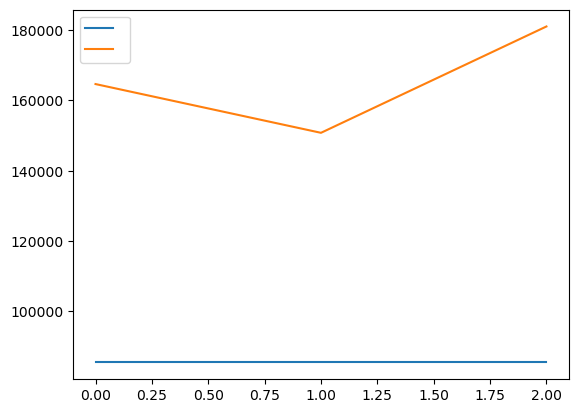

In [611]:
pred_LSTM.plot(legend = True)
actual_LSTM .plot(legend = True)

In [612]:
#Evaluating the model

# MAE
mae = mean_absolute_error(actual_LSTM, pred_LSTM.values)
print(f'MAE: {round(mae, 2)}')

# MSE
mse = mean_squared_error(actual_LSTM, pred_LSTM.values)
print(f'MSE: {round(mse, 2)}')

# RMSE
rmse = np.sqrt(mse)
print(f'RMSE: {round(rmse, 2)}')

# MAPE
mape = np.mean(np.abs((actual_LSTM- pred_LSTM.values) /actual_LSTM)) * 100
print(f'MAPE: {mape:.2f}%')

MAE: 80106.25
MSE: 6570126842.19
RMSE: 81056.32
MAPE: 48.11%


## 4.5 Final Model Building

## 4.6 Testing final model

## 4.7 Summary <a id="3.5.Summary"></a>